# ML_CyberAttack Predictor project


Import libraries :
link to ua-parser library : https://github.com/ua-parser/uap-python



In [57]:
import pandas as pd
from pyexpat import features
from uaparser import UAParser as parse_ua


# DATA CLEAN

In [58]:
dataset_path = 'Data/cybersecurity_attacks.csv'
df = pd.read_csv(dataset_path)
df.head()

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,...,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,...,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,...,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,...,Blocked,Medium,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,"Jaunpur, Rajasthan",NaN,NaN,Alert Data,Firewall
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,...,Blocked,Low,Dhanush Chad,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,"Anantapur, Tripura",149.6.110.119,NaN,Alert Data,Firewall


## Device Information
Device information column return the user agent information or the destination address \
User-agent provide information about the devices : OS, Browsers and device type and brand \
#### **Observation** :
ua-string is unusable as it is an aggregation of string values. Furthermore, some information  \
could lead to confusion as the prefix which could be interpreted as the browser, but which \
is in fact the compatibility of the rendering browser engine. \
*Mozilla/5.0 (iPod; U; CPU iPhone OS 3_0 like Mac OS X; tg-TJ) AppleWebKit/534.33.5 (KHTML, like Gecko) Version/4.0.5 Mobile/8B116 Safari/6534.33.5*  \
For instance this ua above refer to an ipod with Safari browser version as 4.0.5. and an Iphone OS 3.0
#### *Data cleaning*
Extraction of the name and version of the OS, Browser and the type of device to figure out if one is susceptible to \
a specific attack. \
In order to do so, we decide to use the library ua_parser to extract relevant information.  \



In [59]:
"""
Function implementations to parse os,browser and devices
version_os and browser return concatenation of name major_version
"""
def version_os(row):
    ua = row['Device Information']
    parsed_ua = parse_ua(ua)
    os_name = parsed_ua.os['name']
    os_version = parsed_ua.os['version']
    version = os_version.split(".")[0] # return the major of the version (first numbers)

    return f"{os_name} {version}"

def version_browser(row):

    ua = row['Device Information']
    parsed_ua = parse_ua(ua)
    browser_name = parsed_ua.browser['name']
    browser_version = parsed_ua.browser['version']
    version = browser_version.split(".")[0]

    return f"{browser_name} {version}"

def type_device(row):

    ua = row['Device Information']
    parsed_ua = parse_ua(ua)
    device_type = parsed_ua.device['type']
    if device_type is None:
        device_type = "computer"
    return device_type

"""
Create columns by applying the function
"""

df['version_os'] = df.apply(version_os, axis=1)
df['version_browser'] = df.apply(version_browser, axis=1)
df['type_device'] = df.apply(type_device, axis=1)

*Add date information*
Import list_os_browsers.xlsx which contains launch and end_of_care date to OS and browsers in order to compute
- a categorical data : end_of_care which allocates 1 to OS with end of care date
- a numeric hierarchic field : date of OS and browser compared to attack type

In [60]:
#Import tables for OS, Browsers
df_browser_list = pd.read_excel('Data/list_os_ browsers.xlsx', sheet_name='EOC BW')
df_OS_list = pd.read_excel('Data/list_os_ browsers.xlsx', sheet_name='EOC OS')
"""
OS version
"""
#Compute the mean to fill the null values
print(df_OS_list['Date de sortie'].mean().round())
print(df_OS_list['Date de fin de support'].mean().round())
# Merge the table OS
df = df.merge(df_OS_list, how='left', left_on="version_os", right_on="Système d'exploitation")
#Fill NaN with the associate mean
df['Date de sortie'] = df['Date de sortie'].fillna(2011)
df['Date de fin de support'] = df['Date de fin de support'].fillna(2016)
#Create year_attack column in order to compare with date of end_of_care
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['year_attack'] = df['Timestamp'].dt.year
df['os_EndOfCare'] = df.apply(lambda row: 0 if row['year_attack'] < row['Date de fin de support'] else 1, axis=1)
df['os_yold'] = df['year_attack']-df['Date de sortie']
"""
Browser version
"""
df = df.merge(df_browser_list, how='left', left_on="version_browser", right_on= "Bibliothèque")

#Compute the mean to fill the null values
print(df_browser_list ['Date de sortie'].mean().round())
print(df_browser_list ['Date de fin de support'].mean().round())
df['Date de sortie_Brw'] = df['Date de sortie_y'].fillna(2014)
df['Date de fin de support_Brw'] = df['Date de fin de support_y'].fillna(2015)
#compare with date of end_of_care
df['Browser_EndOfCare'] = df.apply(lambda row: 0 if row['year_attack'] < row['Date de fin de support_Brw'] else 1, axis=1)
df['Browser_yold'] = df['year_attack']-df['Date de sortie_Brw']
df_date = df

2011.0
2016.0
2014.0
2015.0


#### *Data cleaning*
Cleaning the dataset after adding information

In [61]:
#drop useless columns
columns_to_drop = ["Geo-location Data","Version_x","Date de sortie_x","Date de fin de support_x","year_attack","Navigateur","Bibliothèque","Version_y","Date de sortie_y","Date de fin de support_y","Système d\'exploitation_y","Date de sortie_Brw","Date de fin de support_Brw"]
df =df.drop(columns_to_drop,axis=1)

df

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,IDS/IPS Alerts,Log Source,version_os,version_browser,type_device,Système d'exploitation_x,os_EndOfCare,os_yold,Browser_EndOfCare,Browser_yold
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,...,NaN,Server,Windows 8,IE 8,computer,Windows 8,1,11.0,1,22.0
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,...,NaN,Firewall,Windows Vista,IE 8,computer,Windows Vista,1,13.0,1,19.0
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,...,Alert Data,Firewall,Windows 8,IE 9,computer,Windows 8,0,10.0,1,16.0
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,...,Alert Data,Firewall,Mac OS 10,Firefox 11,computer,Mac OS 10,1,7.0,1,11.0
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,...,Alert Data,Firewall,Windows 8,IE 5,computer,Windows 8,1,11.0,1,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,2023-05-26 14:08:42,26.36.109.26,121.100.75.240,31005,6764,UDP,1428,Control,HTTP,Quibusdam ullam consequatur consequuntur accus...,...,Alert Data,Firewall,iOS 14,Firefox 17,tablet,iOS 14,1,3.0,1,11.0
39996,2023-03-27 00:38:27,17.21.163.81,196.108.134.78,2553,28091,UDP,1184,Control,HTTP,Quaerat neque esse. Animi expedita natus commo...,...,NaN,Firewall,Windows 98,Safari 4,computer,Windows 98,1,25.0,1,14.0
39997,2022-03-31 01:45:49,162.35.217.57,98.107.0.15,22505,25152,UDP,1043,Data,DNS,Enim at aspernatur illum. Saepe numquam eligen...,...,Alert Data,Server,Windows NT 4,Safari 4,computer,Windows NT 4,1,26.0,1,13.0
39998,2023-09-22 18:32:38,208.72.233.205,173.79.112.252,20013,2703,UDP,483,Data,FTP,Officiis dolorem sed harum provident earum dis...,...,NaN,Server,Linux i686,Chrome 15,computer,NaN,1,12.0,1,12.0


# Data Analysis
## Analyse timestamp

In [62]:
'''df_timestamp = df['Timestamp'].to_timestamp()'''
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['hour'] = df['Timestamp'].dt.hour
def night(hour):
    if hour > 22 or hour < 6:
        return 1
    else:
        return 0
df['night'] = df['hour'].apply( lambda hour: night(hour))


##

Add OS name(brand)

In [63]:
def version_os_name(row):
    ua = row['Device Information']
    parsed_ua = parse_ua(ua)
    os_name = parsed_ua.os['name']
    return os_name
df['version_os_name'] = df.apply(version_os_name, axis=1)

### Users already attacked

In [64]:
#Create a series of users that have been attacked several times
user_nb_attack = df['User Information'].value_counts()
attacked = user_nb_attack[user_nb_attack > 1].index
def attacked_users(row):
    if row['User Information'] in attacked:
        return 1
    else:
        return 0
df['attacked'] = df.apply(lambda row: attacked_users(row), axis=1)
df

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,type_device,Système d'exploitation_x,os_EndOfCare,os_yold,Browser_EndOfCare,Browser_yold,hour,night,version_os_name,attacked
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,...,computer,Windows 8,1,11.0,1,22.0,6,0,Windows,0
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,...,computer,Windows Vista,1,13.0,1,19.0,7,0,Windows,1
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,...,computer,Windows 8,0,10.0,1,16.0,8,0,Windows,0
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,...,computer,Mac OS 10,1,7.0,1,11.0,10,0,Mac OS,0
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,...,computer,Windows 8,1,11.0,1,24.0,13,0,Windows,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,2023-05-26 14:08:42,26.36.109.26,121.100.75.240,31005,6764,UDP,1428,Control,HTTP,Quibusdam ullam consequatur consequuntur accus...,...,tablet,iOS 14,1,3.0,1,11.0,14,0,iOS,0
39996,2023-03-27 00:38:27,17.21.163.81,196.108.134.78,2553,28091,UDP,1184,Control,HTTP,Quaerat neque esse. Animi expedita natus commo...,...,computer,Windows 98,1,25.0,1,14.0,0,1,Windows,0
39997,2022-03-31 01:45:49,162.35.217.57,98.107.0.15,22505,25152,UDP,1043,Data,DNS,Enim at aspernatur illum. Saepe numquam eligen...,...,computer,Windows NT 4,1,26.0,1,13.0,1,1,Windows,1
39998,2023-09-22 18:32:38,208.72.233.205,173.79.112.252,20013,2703,UDP,483,Data,FTP,Officiis dolorem sed harum provident earum dis...,...,computer,NaN,1,12.0,1,12.0,18,0,Linux,1


## Feature Engineering


### Binning values into discrete intervals or binary

Port are bin into the Iana category :
https://www.iana.org/assignments/service-names-port-numbers/service-names-port-numbers.xhtml

In [65]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['year'] = df['Timestamp'].dt.year
df['month'] = df['Timestamp'].dt.month
df['day'] = df['Timestamp'].dt.day
df

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,os_yold,Browser_EndOfCare,Browser_yold,hour,night,version_os_name,attacked,year,month,day
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,...,11.0,1,22.0,6,0,Windows,0,2023,5,30
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,...,13.0,1,19.0,7,0,Windows,1,2020,8,26
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,...,10.0,1,16.0,8,0,Windows,0,2022,11,13
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,...,7.0,1,11.0,10,0,Mac OS,0,2023,7,2
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,...,11.0,1,24.0,13,0,Windows,0,2023,7,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,2023-05-26 14:08:42,26.36.109.26,121.100.75.240,31005,6764,UDP,1428,Control,HTTP,Quibusdam ullam consequatur consequuntur accus...,...,3.0,1,11.0,14,0,iOS,0,2023,5,26
39996,2023-03-27 00:38:27,17.21.163.81,196.108.134.78,2553,28091,UDP,1184,Control,HTTP,Quaerat neque esse. Animi expedita natus commo...,...,25.0,1,14.0,0,1,Windows,0,2023,3,27
39997,2022-03-31 01:45:49,162.35.217.57,98.107.0.15,22505,25152,UDP,1043,Data,DNS,Enim at aspernatur illum. Saepe numquam eligen...,...,26.0,1,13.0,1,1,Windows,1,2022,3,31
39998,2023-09-22 18:32:38,208.72.233.205,173.79.112.252,20013,2703,UDP,483,Data,FTP,Officiis dolorem sed harum provident earum dis...,...,12.0,1,12.0,18,0,Linux,1,2023,9,22


In [66]:
def categorize_port(port):
    if 0 <= port <= 1023:
        return 'SystemPorts'
    elif 1024 <= port <= 49151:
        return 'UserPorts'
    elif 49152 <= port <= 65535:
        return 'Dynamic'
    else:
        return 'Unk'


df['Destination Port'] = df['Destination Port'].apply(categorize_port)

In [67]:
#Improvement make the code fit in all cases not hard coding
import numpy as np
df['packet_length_bins'] = pd.cut(df['Packet Length'], bins=[0, 100, 500, 1500, np.inf], labels=["very small", "small", "medium", "large"])
df =df.drop('Packet Length', axis=1)

In [68]:
def proxyon(row):
    if pd.isna(row):
        return 0
    else:
        return 1


df['ProxyON'] = df.apply(lambda row: proxyon(row['Proxy Information']), axis=1)

df.drop('Proxy Information', axis=1)
def fireon(row):
    if pd.isna(row):
        return 0
    else:
        return 1


df['FireOn'] = df.apply(lambda row: fireon(row['Firewall Logs']), axis=1)
df.drop('Firewall Logs', axis=1)
def idpipson(row):
    if pd.isna(row):
        return 0
    else:
        return 1


df['IDP/IPS On'] = df.apply(lambda row: idpipson(row['IDS/IPS Alerts']), axis=1)
df =df.drop('IDS/IPS Alerts', axis=1)

### Ordinal encoding

Let discuss the good features to encoding in ordinal encoding

In [69]:
#Severity Level
#scikit lear ordinal encoding to look
severity_mapping = {'High': 3, 'Medium': 2, 'Low': 1}
df['Severity Level score'] = df['Severity Level'].map(severity_mapping)
#Malware Indicators BIAS ????
malware_mapping = {'IoC Detected': 1, 'not_detected': 0}
df['MalwareDetect'] = df['Malware Indicators'].map(malware_mapping).fillna(0)
#Alerts BIAS ????
alert_mapping = {'Alert Triggered': 1, 'not_detected': 0}
df['Alert'] = df['Alerts/Warnings'].map(alert_mapping).fillna(0)

In [70]:
columns_to_drop2 = ["Payload Data","Malware Indicators","Alerts/Warnings","Severity Level","User Information","Device Information","Proxy Information","Firewall Logs","version_os","version_browser","Système d\'exploitation_x","hour","Timestamp","type_device"]
df = df.drop(columns_to_drop2, axis=1)
df

,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Type,Traffic Type,Anomaly Scores,Attack Type,Attack Signature,...,year,month,day,packet_length_bins,ProxyON,FireOn,IDP/IPS On,Severity Level score,MalwareDetect,Alert
0,103.216.15.12,84.9.164.252,31225,UserPorts,ICMP,Data,HTTP,28.67,Malware,Known Pattern B,...,2023,5,30,medium,1,1,0,1,1.0,0.0
1,78.199.217.198,66.191.137.154,17245,UserPorts,ICMP,Data,HTTP,51.50,Malware,Known Pattern A,...,2020,8,26,medium,0,1,0,1,1.0,0.0
2,63.79.210.48,198.219.82.17,16811,Dynamic,UDP,Control,HTTP,87.42,DDoS,Known Pattern B,...,2022,11,13,small,1,1,1,1,1.0,1.0
3,163.42.196.10,101.228.192.255,20018,UserPorts,UDP,Data,HTTP,15.79,Malware,Known Pattern B,...,2023,7,2,small,0,0,1,2,0.0,1.0
4,71.166.185.76,189.243.174.238,6131,UserPorts,TCP,Data,DNS,0.52,DDoS,Known Pattern B,...,2023,7,16,medium,1,0,1,1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,26.36.109.26,121.100.75.240,31005,UserPorts,UDP,Control,HTTP,39.28,DDoS,Known Pattern A,...,2023,5,26,medium,0,1,1,2,1.0,0.0
39996,17.21.163.81,196.108.134.78,2553,UserPorts,UDP,Control,HTTP,27.25,DDoS,Known Pattern A,...,2023,3,27,medium,1,1,0,3,1.0,0.0
39997,162.35.217.57,98.107.0.15,22505,UserPorts,UDP,Data,DNS,31.01,DDoS,Known Pattern B,...,2022,3,31,medium,0,1,1,1,1.0,0.0
39998,208.72.233.205,173.79.112.252,20013,UserPorts,UDP,Data,FTP,97.85,Malware,Known Pattern B,...,2023,9,22,small,1,1,0,1,1.0,1.0


# ML

In [71]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

In [72]:
numerical_features  =["Anomaly Scores","os_yold","year",'month','day',"Severity Level score"]
categorical_features  =  ["Destination Port","Protocol","Packet Type","Traffic Type","Attack Signature","Action Taken","Network Segment","Log Source","os_EndOfCare","version_os_name","attacked","packet_length_bins","ProxyON","FireOn","IDP/IPS On","Alert","MalwareDetect"]
features = numerical_features + categorical_features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])


df_scaled = preprocessor.fit_transform(df[features])

kmeans = KMeans(n_clusters=12, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)
correlations = df.select_dtypes(include=np.number).corr()['Cluster']
print("Corrélations avec l’affectation aux cluster:")
print(correlations)


Corrélations avec l’affectation aux cluster:
Source Port            -0.001315
Anomaly Scores          0.097281
os_EndOfCare            0.073475
os_yold                 0.328813
Browser_EndOfCare            NaN
Browser_yold            0.104467
night                   0.001763
attacked               -0.007376
year                   -0.084370
month                  -0.179843
day                     0.057968
ProxyON                -0.012760
FireOn                 -0.008094
IDP/IPS On              0.000143
Severity Level score    0.013928
MalwareDetect           0.001533
Alert                   0.013042
Cluster                 1.000000
Name: Cluster, dtype: float64


In [73]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import RFE

In [74]:
from sklearn.linear_model import LogisticRegression

In [75]:
df

,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Type,Traffic Type,Anomaly Scores,Attack Type,Attack Signature,...,month,day,packet_length_bins,ProxyON,FireOn,IDP/IPS On,Severity Level score,MalwareDetect,Alert,Cluster
0,103.216.15.12,84.9.164.252,31225,UserPorts,ICMP,Data,HTTP,28.67,Malware,Known Pattern B,...,5,30,medium,1,1,0,1,1.0,0.0,0
1,78.199.217.198,66.191.137.154,17245,UserPorts,ICMP,Data,HTTP,51.50,Malware,Known Pattern A,...,8,26,medium,0,1,0,1,1.0,0.0,10
2,63.79.210.48,198.219.82.17,16811,Dynamic,UDP,Control,HTTP,87.42,DDoS,Known Pattern B,...,11,13,small,1,1,1,1,1.0,1.0,3
3,163.42.196.10,101.228.192.255,20018,UserPorts,UDP,Data,HTTP,15.79,Malware,Known Pattern B,...,7,2,small,0,0,1,2,0.0,1.0,8
4,71.166.185.76,189.243.174.238,6131,UserPorts,TCP,Data,DNS,0.52,DDoS,Known Pattern B,...,7,16,medium,1,0,1,1,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,26.36.109.26,121.100.75.240,31005,UserPorts,UDP,Control,HTTP,39.28,DDoS,Known Pattern A,...,5,26,medium,0,1,1,2,1.0,0.0,0
39996,17.21.163.81,196.108.134.78,2553,UserPorts,UDP,Control,HTTP,27.25,DDoS,Known Pattern A,...,3,27,medium,1,1,0,3,1.0,0.0,9
39997,162.35.217.57,98.107.0.15,22505,UserPorts,UDP,Data,DNS,31.01,DDoS,Known Pattern B,...,3,31,medium,0,1,1,1,1.0,0.0,9
39998,208.72.233.205,173.79.112.252,20013,UserPorts,UDP,Data,FTP,97.85,Malware,Known Pattern B,...,9,22,small,1,1,0,1,1.0,1.0,3


In [76]:
numerical_features  =["Anomaly Scores","os_yold","year",'month','day',"Severity Level score"]
categorical_features  =  ["Destination Port","Protocol","Packet Type","Traffic Type","Attack Signature","Action Taken","Network Segment","Log Source","os_EndOfCare","version_os_name","attacked","packet_length_bins","ProxyON","FireOn","IDP/IPS On","Alert","MalwareDetect"]
features = numerical_features + categorical_features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])
X = preprocessor.fit_transform(df[features])
y = df['Attack Type']
selector = RFE(LogisticRegression(max_iter=1000), n_features_to_select=10)
selector.fit(X, y)
# Get selected feature indices
selected_indices = selector.support_

# Map back to original feature names
# First, retrieve feature names after preprocessing
preprocessor_feature_names = (
    numerical_features +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
)

# Get the selected feature names
selected_features = [preprocessor_feature_names[i] for i in range(len(preprocessor_feature_names)) if selected_indices[i]]
print("Selected Features by RFE:", selected_features)

Selected Features by RFE: ['Destination Port_UserPorts', 'Packet Type_Data', 'Action Taken_Blocked', 'Network Segment_Segment B', 'version_os_name_Linux', 'version_os_name_Mac OS', 'version_os_name_iOS', 'packet_length_bins_very small', 'ProxyON_0', 'Alert_0.0']


In [77]:
numerical_features  =[]
categorical_features  =  ['Destination Port', 'Packet Type', 'Action Taken', 'Network Segment', 'version_os_name',  'packet_length_bins', 'ProxyON', 'Alert']
features = numerical_features + categorical_features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])
X = preprocessor.fit_transform(df[features])
y = df['Attack Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))


Accuracy: 0.335875
              precision    recall  f1-score   support

        DDoS       0.34      0.35      0.34      2636
   Intrusion       0.33      0.32      0.33      2721
     Malware       0.34      0.34      0.34      2643

    accuracy                           0.34      8000
   macro avg       0.34      0.34      0.34      8000
weighted avg       0.34      0.34      0.34      8000



python
numerical_features  =["Anomaly Scores","os_yold","year",'month','day',"Severity Level score"]
categorical_features  =  ["Destination Port","Protocol","Packet Type","Traffic Type","Attack Signature","Action Taken","Network Segment","Log Source","os_EndOfCare","version_os_name","attacked","packet_length_bins","ProxyON","FireOn","IDP/IPS On","Alert","MalwareDetect"]
features = numerical_features + categorical_features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])
X = preprocessor.fit_transform(df[features])
y = df['Attack Type']
selector = RFE(LogisticRegression(max_iter=1000), n_features_to_select=10)
selector.fit(X, y)
# Get selected feature indices
selected_indices = selector.support_

# Map back to original feature names
# First, retrieve feature names after preprocessing
preprocessor_feature_names = (
    numerical_features +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
)

# Get the selected feature names
selected_features = [preprocessor_feature_names[i] for i in range(len(preprocessor_feature_names)) if selected_indices[i]]
print("Selected Features by RFE:", selected_features)
numerical_features  =[]
categorical_features  =  ['Destination Port', 'Packet Type', 'Action Taken', 'Network Segment', 'version_os_name',  'packet_length_bins', 'ProxyON', 'Alert']
features = numerical_features + categorical_features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])
X = preprocessor.fit_transform(df[features])
y = df['Attack Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
***********************************************************************************
Accuracy: 0.335875
              precision    recall  f1-score   support

        DDoS       0.34      0.35      0.34      2636
   Intrusion       0.33      0.32      0.33      2721
     Malware       0.34      0.34      0.34      2643

    accuracy                           0.34      8000
   macro avg       0.34      0.34      0.34      8000
weighted avg       0.34      0.34      0.34      8000



In [78]:
numerical_features  =["Anomaly Scores","Cluster"]
categorical_features  =  ["Destination Port","Protocol","Packet Type","Traffic Type","Attack Signature","Action Taken","Network Segment","Log Source","os_EndOfCare","version_os_name","attacked","packet_length_bins","ProxyON","FireOn","IDP/IPS On","Alert","MalwareDetect"]
features = numerical_features + categorical_features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])
X = preprocessor.fit_transform(df[features])
y = df['Attack Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.331375
              precision    recall  f1-score   support

        DDoS       0.33      0.37      0.35      2636
   Intrusion       0.34      0.32      0.33      2721
     Malware       0.32      0.31      0.32      2643

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.33      8000
weighted avg       0.33      0.33      0.33      8000



In [79]:
numerical_features  =["Anomaly Scores",'Severity Level score']
categorical_features  =  ["Protocol",'Traffic Type', 'Destination Port',"packet_length_bins"]


In [80]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])
X = preprocessor.fit_transform(df[features])
y = df['Attack Type']
selector = RFE(LogisticRegression(max_iter=1000), n_features_to_select=10)
selector.fit(X, y)
# Get selected feature indices
selected_indices = selector.support_

# Map back to original feature names
# First, retrieve feature names after preprocessing
preprocessor_feature_names = (
    numerical_features +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
)

# Get the selected feature names
selected_features = [preprocessor_feature_names[i] for i in range(len(preprocessor_feature_names)) if selected_indices[i]]
print("Selected Features by RFE:", selected_features)


ValueError: A given column is not a column of the dataframe

In [28]:
features = ['Anomaly Scores', 'Protocol', 'Traffic Type','Destination Port',"packet_length_bins" ]
numerical_features  =["Anomaly Scores"]
categorical_features  =  ["Protocol",'Traffic Type', 'Destination Port',"packet_length_bins"]

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])
X = preprocessor.fit_transform(df[features])
y = df['Attack Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.333625
              precision    recall  f1-score   support

        DDoS       0.32      0.33      0.32      2636
   Intrusion       0.35      0.34      0.34      2721
     Malware       0.34      0.33      0.33      2643

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.33      8000
weighted avg       0.33      0.33      0.33      8000



## Visualization

Palette creation for visual
color selection : https://colorbrewer2.org/#

In [28]:
import seaborn as sns
palette_os = ['#ca0020','#f4a582','#ffffff','#bababa','#404040']
sns.set_palette(palette_os)
sns.set_theme(style="dark")

### Data

In [29]:
import matplotlib.pyplot as plt


<Axes: xlabel='Attack Type', ylabel='version_os_name'>

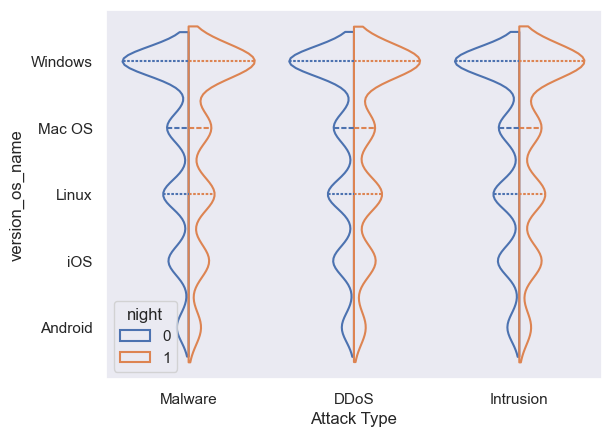

In [30]:
sns.set_theme(style="dark")

sns.violinplot(data=df, x="Attack Type", y="version_os_name", hue="night",
               split=True, inner="quart", fill=False)

<Axes: xlabel='Attack Type', ylabel='Anomaly Scores'>

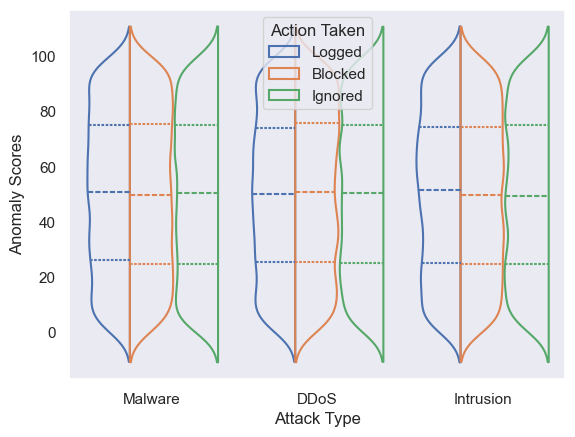

In [31]:
sns.set_theme(style="dark")

sns.violinplot(data=df, x="Attack Type", y="Anomaly Scores", hue="Action Taken",
               split=True, inner="quart", fill=False)